In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

from method_utils import load_dataset
from method_utils import get_generators
from method_utils import get_distances
from method_utils import get_gramian
from method_utils import normalize_distances
from method_utils import get_invariant_measures

from scipy.linalg import expm
from scipy.stats import entropy

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

### Load dataset

In [2]:
dataset_name = 'syn_15_120'

# location: 'datasets' or 'temporal_networks'
location = 'datasets'

vertices, edges, adj_matrices, labels = load_dataset(dataset_name, loc=location)

### Calculate invariant measures

In [3]:
invariant_measures = get_invariant_measures(adj_matrices)

### Compute matrix $K$

In [4]:
distances = get_distances(invariant_measures, norm=2)

Computing distances: 100%|##########| 15/15 [00:00<00:00, 16930.72it/s]


<Axes: >

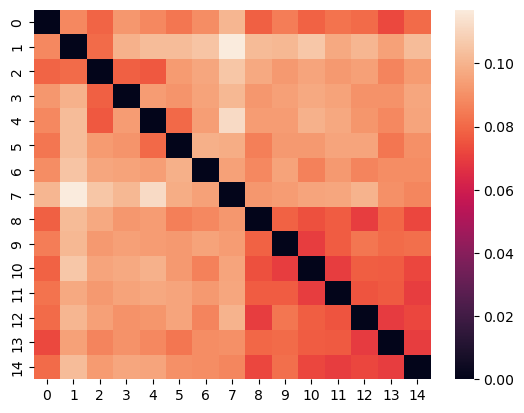

In [5]:
sn.heatmap(distances)

### Compute optimal $\sigma$

In [6]:
def relative_variance(sigma):

    K = get_gramian(distances, sigma)
    
    # Step 1: Mask out the diagonal
    off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]

    # Step 2: Compute variance
    variance = np.var(off_diagonal_entries)
    mean = np.mean(off_diagonal_entries)

    return variance/mean

def uniformity_score(sigma, bins=20):

    K = get_gramian(distances, sigma)
    
    # Step 1: Mask out the diagonal
    off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]
    int_size = np.max(off_diagonal_entries) - np.min(off_diagonal_entries)

    counts, _ = np.histogram(off_diagonal_entries, bins=bins, range=(np.min(off_diagonal_entries), np.max(off_diagonal_entries)), density=False)
    probs = counts / counts.sum()
    return int_size * entropy(probs, base=np.e) / np.log(bins)

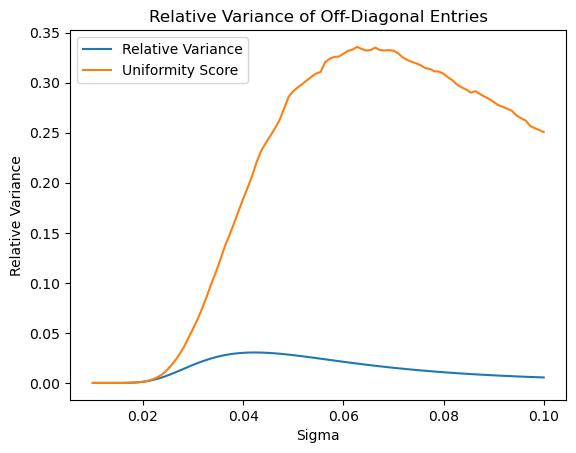

Optimal sigma (relative variance): 0.04272727272727273
Optimal sigma (uniformity): 0.06272727272727273


Max relative variance: 0.03040449352108989
Max uniformity: 0.3357337386162929


In [7]:
sigma_values = np.linspace(0.01, 0.1, 100)
relative_variances = [relative_variance(sigma) for sigma in sigma_values]
uniformity_scores = [uniformity_score(sigma) for sigma in sigma_values]
plt.plot(sigma_values, relative_variances)
plt.plot(sigma_values, uniformity_scores)
plt.legend(['Relative Variance', 'Uniformity Score'])
plt.xlabel('Sigma')
plt.ylabel('Relative Variance')
plt.title('Relative Variance of Off-Diagonal Entries')
plt.show()

sigma_max_variance = sigma_values[np.argmax(relative_variances)]
sigma_max_uniformity = sigma_values[np.argmax(uniformity_scores)]
relative_variance_max = np.max(relative_variances)
uniformity_score_max = np.max(uniformity_scores)
print(f"Optimal sigma (relative variance): {sigma_max_variance}")
print(f"Optimal sigma (uniformity): {sigma_max_uniformity}")
print("\n")
print(f"Max relative variance: {relative_variance_max}")
print(f"Max uniformity: {uniformity_score_max}")

In [8]:
sigma = 0.05
K = get_gramian(distances, sigma)
np.fill_diagonal(K, 0)

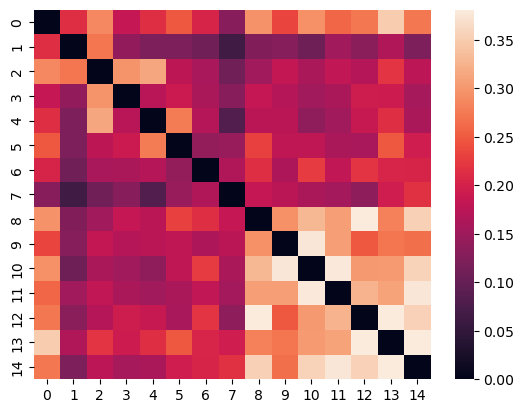

In [9]:
sn.heatmap(K)
plt.show()

# Step 1: Mask out the diagonal
off_diagonal_entries = K[~np.eye(K.shape[0], dtype=bool)]

# Step 2: Compute variance
variance = np.var(off_diagonal_entries)
mean = np.mean(off_diagonal_entries)

### Compute temporal generator $L_{temp}$.

In [10]:
L_temp = get_generators(K)

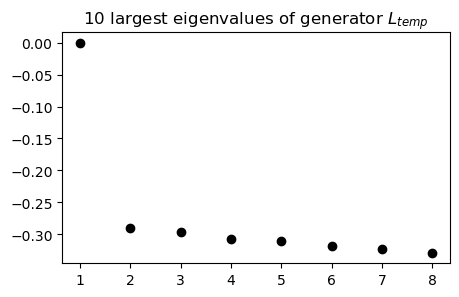

In [11]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generator $L_{temp}$")
x_axis = np.arange(1,9)
plt.xticks(x_axis)

L_temp_eigvals, L_temp_eigvecs = np.linalg.eig(L_temp)
L_temp_eigvals_sorted = np.sort(L_temp_eigvals)[-8:][::-1]
plt.scatter(x=x_axis, y=L_temp_eigvals_sorted, c='black')

### Set $\tau_{temp}$ and compute $P_{temp}^{\tau_{temp}}$

In [12]:
tau_temp = 3
P_temp = expm(L_temp*tau_temp)

### Spectral clustering of $P^{\tau_{temp}}_{temp}$.

Determine dominant eigenvalues of transition matrix $P^{\tau}_{temp}$

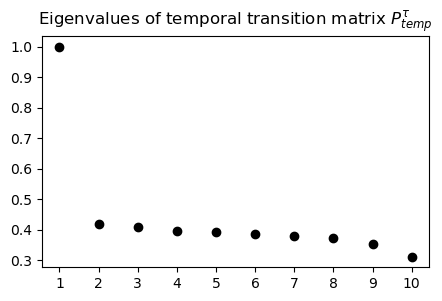

In [13]:
P_temp_eigval, P_temp_eigvec = np.linalg.eig(P_temp)
indices = np.argsort(P_temp_eigval)[-10:][::-1]
P_temp_eigval_sorted = P_temp_eigval[indices]
P_temp_eigvec_sorted = P_temp_eigvec[:, indices]

plt.figure(figsize=(5, 3))
plt.title("Eigenvalues of temporal transition matrix $P_{temp}^{\\tau}$")
plt.xticks(np.arange(1,11))
plt.scatter(np.arange(1, 11), P_temp_eigval_sorted, c='black')

Get snapshot embeddings

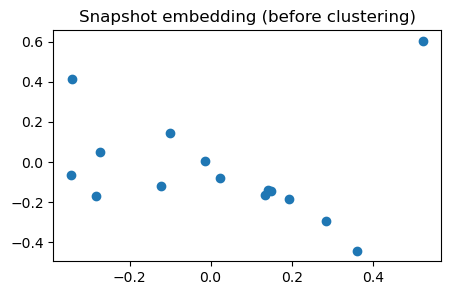

In [14]:
dominant_eigenvalues = 2

data = P_temp_eigvec_sorted[:, :dominant_eigenvalues]

plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(5,3))
plt.title("Snapshot embedding (before clustering)")
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1])

Perform spectral clustering

In [15]:
kmeans = KMeans(n_clusters=dominant_eigenvalues, n_init=10, random_state=0)
kmeans.fit(np.real(data))

predicted_labels = kmeans.labels_

### Compute ARI score

In [16]:
ari = adjusted_rand_score(labels, predicted_labels)
print(f"ARI: {ari*100}")

ARI: 50.255102040816325


### Compute NMI score

In [17]:
nmi = normalized_mutual_info_score(labels, predicted_labels)
print(f"NMI score: {nmi}")

NMI score: 0.43216317076589905


### Get Distance matrix (IMC)

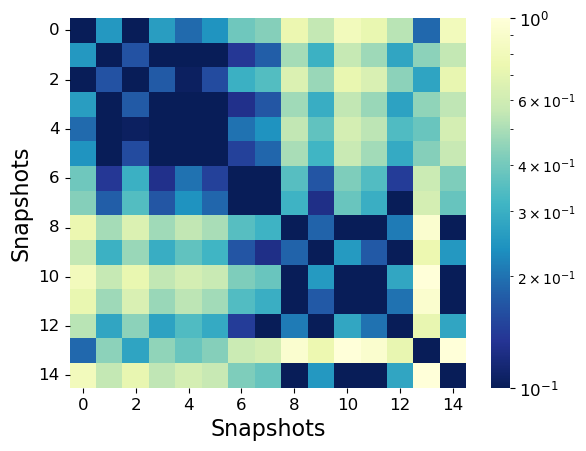

In [18]:
distance_matrix = np.zeros(shape=(len(adj_matrices), len(adj_matrices)))

for i in range(len(adj_matrices)):
    for j in range(len(adj_matrices)):
        distance_matrix[i, j] = np.linalg.norm(data[i,:] - data[j,:])

distance_matrix_norm, min_distance, max_distance = normalize_distances(distance_matrix)
np.fill_diagonal(distance_matrix_norm, 0.1)

ax = sn.heatmap(distance_matrix_norm, annot=False, annot_kws={"size": 16}, cmap="YlGnBu_r", norm=LogNorm(0.1,1))

# Set axis labels
ax.set_xlabel("Snapshots", fontsize=16)
ax.set_ylabel("Snapshots", fontsize=16)

# Specify the ticks you want
x_ticks_labels = [0, 2, 4, 6, 8, 10, 12, 14]  # corresponding labels
x_ticks_positions = np.array(x_ticks_labels) + 0.5 # positions (index)

y_ticks_labels = [0, 2, 4, 6, 8, 10, 12, 14]
y_ticks_positions = np.array(y_ticks_labels) + 0.5

# Set them
ax.set_xticks(x_ticks_positions)
ax.set_xticklabels(x_ticks_labels, fontsize=12)

ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(y_ticks_labels, fontsize=12)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

# # Customize colorbar ticks and labels
cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.1, 0.2,0.4, 0.6, 0.8, 1])  # Adjust based on your data
#cbar.set_ticklabels(["0.1", "0.2", "0.4", "0.6", "0.8", "1"])
cbar.ax.tick_params(labelsize=12)  # Optional: change label size